In [1]:
# Import the packages
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import r2_score
from sqlalchemy import create_engine


In [2]:
plt.style.use('dark_background')
#resize plot to wide form
plt.rcParams['figure.figsize'] = [20, 4]
#shrink plot labels
plt.rcParams.update({'font.size': 12})
#remove all boundaries
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [3]:
def bulk_insert(df, table_name, conn_string):
    conn = psycopg2.connect(conn_string)
    cur = conn.cursor()
    output = io.StringIO()
    df.to_csv(output, sep='\t', header=False, index=True)
    output.seek(0)
    cur.copy_from(output,table_name, null="")
    conn.commit()
    conn.close()


In [4]:
data_raw = pd.read_csv('raw_island_days2.csv', delimiter = ',')

#get data_raw length
data_raw_length = len(data_raw)

#get split index for train and test
#split_index = int(data_raw_length*.8)
split_index = 25968

#set datatype to datetime for first column in data_raw
data_raw['time'] = pd.to_datetime(data_raw['time'])
data_raw.set_index('time', inplace=True)


#smooth data (averaging small cyclical changes like tide)
sm_len = 7
data_raw_sm = data_raw.rolling(sm_len).mean()

data_train = data_raw_sm.iloc[split_index-2000:(split_index)]
data_test = data_raw_sm.iloc[(split_index):]

print(data_train.shape)

(2000, 20)


## DB connection

In [5]:
## fill your db information
database = '' # FILL IN your db name where tspdb is installed
user = 'postgres' #  FILL IN  user name here
password = '00' #  # FILL IN  password here
host = 'localhost' #  # FILL IN  host name
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)
driver="postgresql"
engine = create_engine(driver + '://' + user + ':' + password + '@' + host + '/' + database)

## Create Time Series Table

In [6]:
conn = psycopg2.connect(conn_string)

cur = conn.cursor()

# Drop the table if it already exists
cur.execute("DROP table IF EXISTS island_test_2;")
conn.commit()
conn.close()

# load data into Pandas dataframe
data_train.to_sql('island_test_2', engine, index=True, index_label='time')
data_train.to_csv('island_test_2.csv')
print('Table created and Loaded')

Table created and Loaded


In [7]:
# lets query our table mixturets2 to inspect its column 
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from island_test_2 order by time DESC limit 10;", conn)
conn.close()
df

/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_38296/4001382400.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("select * from island_test_2 order by time DESC limit 10;", conn)


,time,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
0,2020-07-07,125.740116,126.576919,126.323277,101.334575,77.990290,66.617043,63.223851,66.552845,79.130346,...,150.469588,110.188343,84.056837,71.563227,67.007667,68.663874,77.659266,98.109896,122.660636,128.295430
1,2020-07-06,123.989323,123.854833,122.984725,99.805529,78.952297,68.941636,66.234534,69.912132,82.447875,...,147.427786,108.968369,83.724825,71.614707,67.584310,69.884732,79.538436,99.689305,122.699875,127.408811
2,2020-07-05,124.275986,122.876599,120.545192,99.841675,79.534342,69.669476,67.130999,71.188241,85.099860,...,144.183765,105.786219,82.603602,71.788700,68.510344,71.259676,81.061469,100.796795,122.792249,127.655994
3,2020-07-04,122.449377,121.456389,118.778435,97.886836,78.454363,69.301492,67.405900,72.378311,88.234643,...,141.356642,108.641553,84.076610,72.120145,68.463466,71.071533,80.965394,101.650453,123.023958,125.802312
4,2020-07-03,119.286958,119.192294,115.949075,96.215173,79.275020,71.576604,70.630879,76.326501,92.529089,...,135.740684,110.573864,86.334064,74.369577,70.810959,73.596397,83.593506,103.431726,120.702007,121.618607
5,2020-07-02,116.342219,117.559490,114.652437,95.988266,80.353967,73.060713,72.463957,78.888325,96.436492,...,131.159474,111.611342,89.067546,77.559382,74.059066,76.669965,86.067488,104.201918,117.157361,116.966627
6,2020-07-01,114.470988,116.364287,113.008638,96.433459,82.812810,76.210630,75.848540,82.257073,99.102457,...,130.227193,112.052216,87.935795,76.914106,73.935845,77.048017,87.067836,105.536723,115.525781,114.628461
7,2020-06-30,114.161689,116.469570,113.484170,96.279313,82.042742,75.283544,74.972678,81.804983,100.489297,...,131.115292,112.684447,85.761269,74.406613,71.801336,75.687115,87.252014,108.139832,116.430433,114.344704
8,2020-06-29,115.283674,118.809872,115.578543,94.754037,79.001748,71.937042,71.917395,79.783073,101.192137,...,131.773634,112.188125,85.415865,74.133384,71.693174,75.883258,87.937214,108.515163,115.793118,114.287730
9,2020-06-28,114.640352,117.931877,114.460188,95.218988,80.717413,73.830581,73.717037,81.343170,101.463586,...,131.244584,111.822184,85.231261,74.117575,71.824470,76.129211,88.208321,108.592072,115.461133,113.745743


## Create prediction index

In [8]:
# get all columns and format it
cols = '{"'+'","'.join(data_train.columns[:])+'"}'
query = """select create_pindex('island_test_2', 'time','%s','pindex_isl2', k=> 20);"""%cols
print('formated query : ',query )
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute(query)
conn.commit()
conn.close()

formated query :  select create_pindex('island_test_2', 'time','{"MT_001","MT_002","MT_003","MT_004","MT_005","MT_006","MT_007","MT_008","MT_009","MT_010","MT_011","MT_012","MT_013","MT_014","MT_015","MT_016","MT_017","MT_018","MT_019","MT_020"}','pindex_isl2', k=> 20);


In [9]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from list_pindices()", conn)
df

/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_38296/1280691254.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("select * from list_pindices()", conn)


,index_name,value_columns,relation,time_column,initial_timestamp,last_timestamp,agg_interval,uncertainty_quantification
0,basic_pindex,[ts],ts_basic_ts_5_5,time,2012-10-01 00:00:00,2012-10-06 18:53:15,00:00:05,True
1,pindex_isl1,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_1,time,1949-06-09 00:00:00,2020-07-13 00:00:00,24:00:00,True
2,pindex_isl2,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_2,time,2015-01-16 00:00:00,2020-07-07 00:00:00,24:00:00,True
3,mixturets_var_pindex,[ts],mixturets_var,time,0,99999,1 units,True
4,mixturets2_pindex,[ts],mixturets2,time,0,100000,1 units,True
5,pindex_e20,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_1,time,1949-06-09 00:00:00,2020-07-13 00:00:00,24:00:00,True
6,pindex_isl3,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_3,time,2019-12-21 00:00:00,2020-07-07 00:00:00,24:00:00,True


## Prediction Queries

/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_38296/1626388267.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('''select * from predict('island_test_2','MT_020','2020-07-13 00:00:00'\


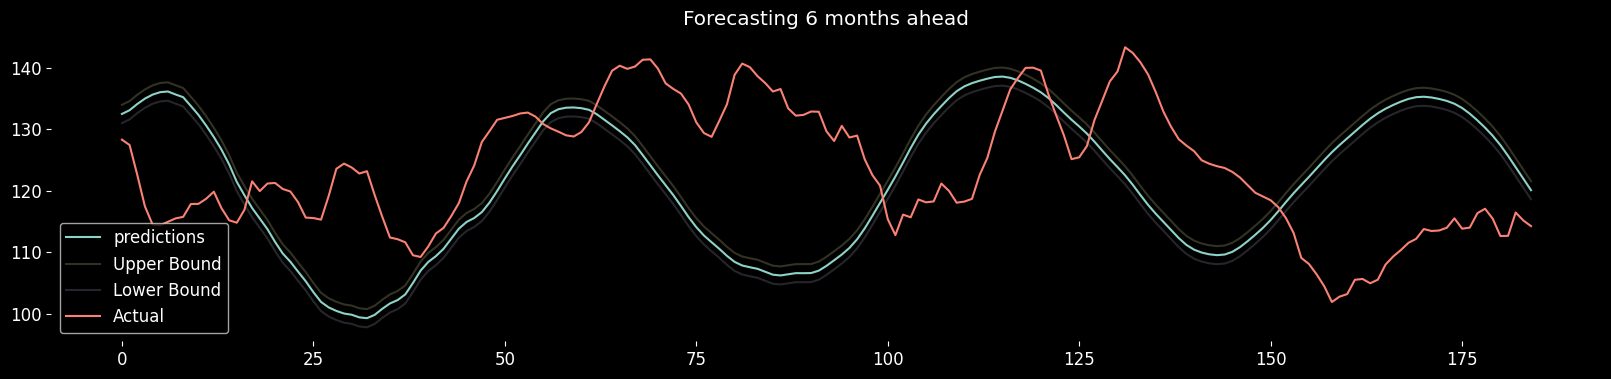

In [10]:
%matplotlib inline
df = pd.read_sql_query('''select * from predict('island_test_2','MT_020','2020-07-13 00:00:00'\
,'2021-01-13 00:00:00','pindex_isl2');''', conn)

plt.figure()
plt.plot( df['prediction'], label = 'predictions')
plt.plot( df['ub'], label = 'Upper Bound', alpha = 0.2)
plt.plot(df['lb'], label = 'Lower Bound', alpha = 0.2)
plt.plot(data_test['MT_020'].values[:len(df['prediction'])], label = 'Actual', alpha = 1.0)
plt.title('Forecasting 6 months ahead')
plt.legend()
plt.show()

Let's calculate the error using the metric Weighted Absolute Percent Error (WAPE) which is calculated as:

$\text{WAPE} = \frac{\sum_i \sum_j |Y_{ij}-\hat{Y}_{ij}|} {\sum_i \sum_j |Y_{ij}|} $

Where:
- $Y_{ij}$ is the actual observation for time series j at time i 
- $\hat{Y}_{ij}$ is the predicted value for time series j at time i 

In [11]:
Y = data_test['MT_020'].values[:len(df['prediction'])]
Y_h = df['prediction']
wape = np.sum(np.abs(Y-Y_h))/np.sum(np.abs(Y))
print ('Forecasting accuracy (WAPE):',wape)

Forecasting accuracy (WAPE): 0.11116131937857857
